INFO: run with conda environment sc-de

31.10.2022

Single-cell RNA-seq analysis - Format pseudocounts and metadata and save as rds files

In [1]:
library(DESeq2)
library(dplyr)
library(magrittr)
library(stringr)
library(purrr)
library(pheatmap)
library(tibble)
library(tidyverse)
library(variancePartition)
library(PCAtools)
library(Hmisc) # for imputation of RIN value

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The followin

In [2]:
# define pathes to data and folders
basedir <- '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/'
tabledir <- file.path(basedir, 'scripts/RNA/08_DEanalysis/DESeq2_RELN/data')
print(tabledir)

[1] "/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain//scripts/RNA/08_DEanalysis/DESeq2_RELN/data"


## 1. Read data

In [3]:
counts <- read.csv(file.path(tabledir, 'pseudocounts.csv'), header = FALSE)
dim(counts)

[1]  1648 26195

In [4]:
groups <- read.csv(file.path(tabledir, 'group_assignment_pseudocounts.csv'))
head(groups)

X,index,group
672583,AGGGTTTGTATGCAAA-1-81-80,Astro_FB__SU255_PFC_RNA
673200,ATCGGATCATACAGGG-1-81-80,Astro_FB__SU255_PFC_RNA
681486,TCATATCGTTTGTGGT-1-81-80,Astro_FB__SU255_PFC_RNA
673224,ATCGTAGCAGCCTACG-1-81-80,Astro_FB__SU255_PFC_RNA
673266,ATCTCTACAGCGAACA-1-81-80,Astro_FB__SU255_PFC_RNA
681484,TCATATCGTGGTCCGT-1-81-80,Astro_FB__SU255_PFC_RNA


In [5]:
group_counts <- read.csv(file.path(tabledir, 'pseudosamples.csv')) %>%
    separate(group, c('Celltype', 'Sample'), sep = '__', remove = FALSE)
group_counts

cell_counts <- group_counts %>%                                        # Specify data frame
  group_by(Sample) %>%                         # Specify group indicator
  summarise_at(vars(counts),              # Specify column
               list(cell_count_sample = sum)) 
cell_counts

X,group,Celltype,Sample,counts
320,Astro_FB__SU255_PFC_RNA,Astro_FB,SU255_PFC_RNA,605
657,Astro_FB__SU294_PFC_RNA,Astro_FB,SU294_PFC_RNA,375
540,Astro_FB__SU306_PFC_RNA,Astro_FB,SU306_PFC_RNA,437
889,Astro_FB__SU308_PFC_RNA,Astro_FB,SU308_PFC_RNA,252
583,Astro_FB__SU319_PFC_RNA,Astro_FB,SU319_PFC_RNA,408
551,Astro_FB__SU323_PFC_RNA,Astro_FB,SU323_PFC_RNA,432
507,Astro_FB__SU331_PFC_RNA,Astro_FB,SU331_PFC_RNA,460
1073,Astro_FB__SU333_PFC_RNA,Astro_FB,SU333_PFC_RNA,182
1526,Astro_FB__SU338_PFC_RNA,Astro_FB,SU338_PFC_RNA,47
1061,Astro_FB__SU339_PFC_RNA,Astro_FB,SU339_PFC_RNA,186


Sample,cell_count_sample
SU255_PFC_RNA,14144
SU294_PFC_RNA,12350
SU306_PFC_RNA,12661
SU308_PFC_RNA,6495
SU319_PFC_RNA,7284
SU323_PFC_RNA,10502
SU331_PFC_RNA,9946
SU333_PFC_RNA,6538
SU338_PFC_RNA,4263
SU339_PFC_RNA,11783


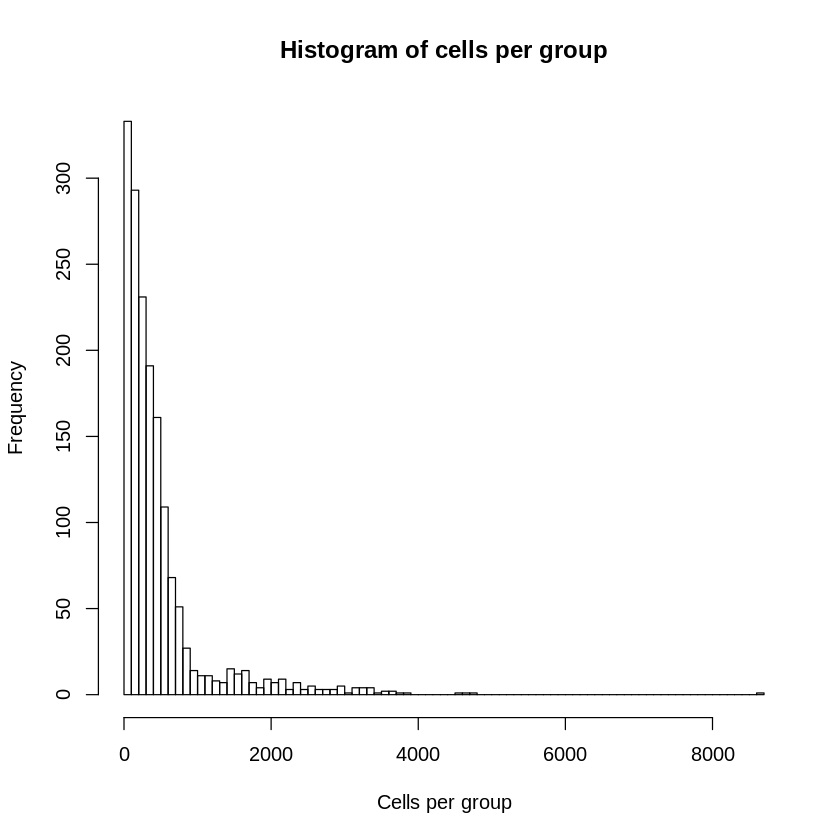

In [6]:
hist(group_counts$counts, breaks = 100, xlab = "Cells per group", main = "Histogram of cells per group")

In [7]:
genes <- read.csv(file.path(tabledir, 'geneIDs_pseudocounts.csv'))
head(genes)

X,gene_ids
AL627309.1,ENSG00000238009
AL627309.5,ENSG00000241860
LINC01409,ENSG00000237491
LINC01128,ENSG00000228794
LINC00115,ENSG00000225880
FAM41C,ENSG00000230368


In [8]:
dim(genes)

[1] 26195     2

In [9]:
colnames(counts) <- genes$gene_ids
rownames(counts) <- group_counts$group

In [10]:
counts[1:5, 1:5]

,ENSG00000238009,ENSG00000241860,ENSG00000237491,ENSG00000228794,ENSG00000225880
Astro_FB__SU255_PFC_RNA,0,9,8,13,1
Astro_FB__SU294_PFC_RNA,0,0,8,9,0
Astro_FB__SU306_PFC_RNA,1,2,4,8,0
Astro_FB__SU308_PFC_RNA,0,0,9,9,1
Astro_FB__SU319_PFC_RNA,0,2,6,12,0


In [11]:
# Not every cluster is present in all samples; create a vector that represents how to split samples
splitf <- sapply(stringr::str_split(rownames(counts), 
                                    pattern = "__",  
                                    n = 2), 
                 `[`, 1)
head(splitf)

[1] "Astro_FB" "Astro_FB" "Astro_FB" "Astro_FB" "Astro_FB" "Astro_FB"

In [12]:
# Turn into a list and split the list into components for each cluster and transform, so rows are genes and columns are samples and make rownames as the sample IDs
counts_split <- split.data.frame(counts, 
                       factor(splitf)) %>%
        lapply(function(u) 
                set_colnames(t(u), 
                             str_split(rownames(u), '__', simplify = TRUE)[,2]))

class(counts_split)

# Explore the different components of list
str(counts_split)

[1] "list"

List of 19
 $ Astro_FB       : num [1:26195, 1:87] 0 9 8 13 1 0 5 1 3 20 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:26195] "ENSG00000238009" "ENSG00000241860" "ENSG00000237491" "ENSG00000228794" ...
  .. ..$ : chr [1:87] "SU255_PFC_RNA" "SU294_PFC_RNA" "SU306_PFC_RNA" "SU308_PFC_RNA" ...
 $ Astro_PP       : num [1:26195, 1:87] 0 10 39 36 3 2 0 2 3 3 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:26195] "ENSG00000238009" "ENSG00000241860" "ENSG00000237491" "ENSG00000228794" ...
  .. ..$ : chr [1:87] "SU255_PFC_RNA" "SU294_PFC_RNA" "SU306_PFC_RNA" "SU308_PFC_RNA" ...
 $ Endothelial    : num [1:26195, 1:87] 2 3 9 5 1 0 0 0 2 3 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:26195] "ENSG00000238009" "ENSG00000241860" "ENSG00000237491" "ENSG00000228794" ...
  .. ..$ : chr [1:87] "SU255_PFC_RNA" "SU294_PFC_RNA" "SU306_PFC_RNA" "SU308_PFC_RNA" ...
 $ Exc_L2-3       : num [1:26195, 1:87] 16 80 571 781 59 37 5 1 1 2 ...
  ..- attr(*, "dimnames")=List of 2
  .

### 2.1 Sample level metadata

In [13]:
# Get sample names for each of the cell type clusters

# prep. data.frame for plotting
get_sample_ids <- function(x){
        counts_split[[x]] %>%
                colnames()
}

de_samples <- map(1:length(counts_split), get_sample_ids) %>%
        unlist()

head(de_samples)
length(de_samples)

[1] "SU255_PFC_RNA" "SU294_PFC_RNA" "SU306_PFC_RNA" "SU308_PFC_RNA"
[5] "SU319_PFC_RNA" "SU323_PFC_RNA"

[1] 1648

In [14]:
# Get cluster IDs for each of the samples

samples_list <- map(1:length(counts_split), get_sample_ids)

get_cluster_ids <- function(x){
        rep(names(counts_split)[x], 
            each = length(samples_list[[x]]))
}

de_cluster_ids <- map(1:length(counts_split), get_cluster_ids) %>%
        unlist()

head(de_cluster_ids)
length(de_cluster_ids)

[1] "Astro_FB" "Astro_FB" "Astro_FB" "Astro_FB" "Astro_FB" "Astro_FB"

[1] 1648

In [15]:
# Create a data frame with the sample IDs, cluster IDs and condition

gg_df <- data.frame(cluster_id = de_cluster_ids,
                    sample_id = de_samples)
head(gg_df)

cluster_id,sample_id
Astro_FB,SU255_PFC_RNA
Astro_FB,SU294_PFC_RNA
Astro_FB,SU306_PFC_RNA
Astro_FB,SU308_PFC_RNA
Astro_FB,SU319_PFC_RNA
Astro_FB,SU323_PFC_RNA


In [16]:
# add phenotype data to adata.obs
phenotype <- read.csv(file.path(basedir, 'phenotype/phenotype_clean.csv')) %>%
    mutate(ID = paste0('SU',SU.Number,'_PFC_RNA'))
head(phenotype)
colnames(phenotype)

SU.Number,Age,AgeBin,Sex,Ethnic.origin,Status,Classification,Classification.detail,Trauma.Code,Trauma.notes.medical.history,...,alcohol.intake..g.day.past.12.mth.,Age.of.onset,Agonal.score,Main.Batch,X6.Batch,Position,Group,Operator,aaa,ID
404,60,60-69,Male,European,1,BipolarDisorder,Bipolar Disorder,0,aged 30 diagnosed with bipolar. Major depressive episodes. Cause of death suicide,...,0,30,1,1,1,1,normalRIN,0,Anna,SU404_PFC_RNA
350,73,70-79,Male,European,1,SchizoaffectiveDisorder,Schizoaffective,0,Age 21 schizophrenia diagnosed. Anxiety and depression entire life.,...,NA,21,0,1,1,2,normalRIN,1,Miriam,SU350_PFC_RNA
383,30,30-39,Male,European,1,SchizoaffectiveDisorder,Schizoaffective,0,psychotic depression for many years. Death by suicide.,...,NA,27,1,1,1,3,normalRIN,0,Anna,SU383_PFC_RNA
583,59,50-59,Male,European,0,Control,Control <20g,1,No trauma,...,4,NA,0,1,1,4,normalRIN,1,Miriam,SU583_PFC_RNA
365,57,50-59,Male,European,1,SchizoaffectiveDisorder,Schizoaffective Disorder,0,aged 30 diagnosed with schizoaffective disorder.ECT,...,20,30,0,1,1,5,normalRIN,0,Anna,SU365_PFC_RNA
632,41,40-49,Male,European,1,MajorDepression,Major Depression,2,Separation from wife. Depressive episodes following that.,...,42,26,0,1,1,6,normalRIN,1,Miriam,SU632_PFC_RNA


[1] "SU.Number"                          "Age"                               
 [3] "AgeBin"                             "Sex"                               
 [5] "Ethnic.origin"                      "Status"                            
 [7] "Classification"                     "Classification.detail"             
 [9] "Trauma.Code"                        "Trauma.notes.medical.history"      
[11] "PMI"                                "Hemisphere"                        
[13] "Brain.pH"                           "RIN"                               
[15] "Chlorpromazine.equivalent"          "Antidepressants"                   
[17] "Mode.of.death"                      "Manner.of.Death"                   
[19] "Suicide"                            "COD.category"                      
[21] "positive.Toxicology"                "Antipsychotics"                    
[23] "Duration.of.psych.illness"          "Antipsychotics.meds.pres"          
[25] "Smoking.status"                     "Freezer.storage.time..days."       
[27] "alcohol.intake..g.day.past.12.mth." "Age.of.onset"                      
[29] "Agonal.score"                       "Main.Batch"                        
[31] "X6.Batch"                           "Position"                          
[33] "Group"                              "Operator"                          
[35] "aaa"                                "ID"

In [17]:
phenotype$RIN <- with(phenotype, impute(RIN, median))
print(phenotype$RIN)

 [1] 6.7  7.5* 8.4  7.0  7.2  8.9  8.0  7.0  6.3  4.4  8.2  7.0  7.7  7.5  7.2 
[16] 6.7  7.9  7.3  8.2  6.2  5.5  8.2  8.1  8.0  6.5  7.6  4.1  5.2  8.5  6.4 
[31] 6.1  8.8  6.2  7.0  7.1  6.3  6.6  6.3  7.9  7.5  8.6  8.6  7.6  7.3  6.7 
[46] 7.8  5.3  7.4  8.0  5.8  8.1  7.5  7.8  6.8  8.1  7.9  8.6  7.3  8.7  6.5 
[61] 8.1  7.9  6.3  6.1  7.6  6.3  8.1  7.7  8.5  6.2  8.6  6.8  7.9  8.8  7.7 
[76] 8.0  7.6  7.6  6.3  5.6  9.0  7.9  6.5  8.3  5.4  7.9  9.0  8.9  7.5  7.6 
[91] 2.9  2.3 


In [18]:
metadata <- left_join(gg_df, phenotype[, c("Status", "Classification", "Age", "Sex", "Brain.pH", "PMI", "RIN", "X6.Batch", "Agonal.score", "Mode.of.death", "ID")], 
                  by = c("sample_id" = "ID"))
head(metadata)
metadata$RIN <- as.numeric(metadata$RIN)
metadata$sample_id <- as.factor(metadata$sample_id)
metadata$Status <- as.factor(metadata$Status)
metadata$X6.Batch <- as.factor(metadata$X6.Batch)
metadata$RIN2 <- (metadata$RIN)**2
str(metadata)

Warning message:
“Column `sample_id`/`ID` joining factor and character vector, coercing into character vector”

cluster_id,sample_id,Status,Classification,Age,Sex,Brain.pH,PMI,RIN,X6.Batch,Agonal.score,Mode.of.death
Astro_FB,SU255_PFC_RNA,1,Schizophrenia,51,Male,6.62,18.0,7.5,15,0,Rapid
Astro_FB,SU294_PFC_RNA,1,MajorDepression,64,Male,6.60,24.0,7.6,15,0,Rapid
Astro_FB,SU306_PFC_RNA,1,Schizophrenia,66,Female,6.52,12.5,8.1,10,0,Rapid
Astro_FB,SU308_PFC_RNA,1,Schizophrenia,40,Male,6.20,21.5,7.6,13,1,Rapid
Astro_FB,SU319_PFC_RNA,1,Schizophrenia,55,Male,6.34,72.0,6.4,5,0,Rapid
Astro_FB,SU323_PFC_RNA,0,Control,33,Female,6.77,24.0,7.7,13,0,Rapid


'data.frame':	1648 obs. of  13 variables:
 $ cluster_id    : Factor w/ 19 levels "Astro_FB","Astro_PP",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ sample_id     : Factor w/ 87 levels "SU255_PFC_RNA",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Status        : Factor w/ 2 levels "0","1": 2 2 2 2 2 1 2 2 1 1 ...
 $ Classification: Factor w/ 5 levels "BipolarDisorder",..: 5 3 5 5 5 2 3 5 2 2 ...
 $ Age           : int  51 64 66 40 55 33 35 54 82 56 ...
 $ Sex           : Factor w/ 2 levels "Female","Male": 2 2 1 2 2 1 1 2 1 2 ...
 $ Brain.pH      : num  6.62 6.6 6.52 6.2 6.34 6.77 6.8 6.17 6.45 6.76 ...
 $ PMI           : num  18 24 12.5 21.5 72 24 27 27.5 7.5 37 ...
 $ RIN           : num  7.5 7.6 8.1 7.6 6.4 7.7 8.5 5.6 7 5.4 ...
 $ X6.Batch      : Factor w/ 16 levels "1","2","3","4",..: 15 15 10 13 5 13 5 14 2 15 ...
 $ Agonal.score  : int  0 0 0 1 0 0 1 0 3 0 ...
 $ Mode.of.death : Factor w/ 3 levels "Intermediate",..: 3 3 3 3 3 3 3 3 2 1 ...
 $ RIN2          : num  56.2 57.8 65.6 57.8 41 ...


In [19]:
table(metadata$Mode.of.death)
levels(metadata$Mode.of.death) <- c("Rapid", "Intermediate", "Long term")


Intermediate    Long term        Rapid 
         587           95          966 

In [20]:
# Add new agonal score that is binary (0 vs 1 and more)
metadata$Agonal.score.new <- metadata$Agonal.score >= 1

In [21]:
# add first MD components from genotype data
mds <- read.table(file.path(basedir, 'tables/NSWbrain.mds'), header=T) %>%
    mutate(IID = paste0(IID,'_PFC_RNA'))
head(mds)

metadata <- left_join(metadata, mds[, c("IID", "C1", "C2", "C3", "C4", "C5")], 
                  by = c("sample_id" = "IID"))
head(metadata)

FID,IID,SOL,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
1,SU331_PFC_RNA,0,-0.00815310,-0.001604480,-0.001190680,0.000808561,-0.00187977,0.000963227,0.00034080,-0.000477774,9.44130e-06,0.000153317
2,SU429_PFC_RNA,0,0.00298041,-0.006092960,0.010482300,-0.023795100,-0.00391104,0.007258730,0.02950410,0.013272100,1.72967e-02,0.003070690
3,SU710_PFC_RNA,0,0.01261970,0.034490700,-0.007766740,0.016090100,0.01163830,-0.007056300,0.02498680,0.009254010,1.43365e-02,0.006497980
4,SU828_PFC_RNA,0,0.01832960,0.000563272,-0.013379500,0.033681200,0.01415460,-0.012506500,0.01477360,0.021686000,1.89797e-02,-0.002653420
5,SU795_PFC_RNA,0,-0.00679840,0.003997200,-0.000314595,0.012395400,0.01432770,0.032230300,-0.02809250,0.018264200,8.64367e-03,0.002784980
6,SU390_PFC_RNA,0,-0.00569778,0.012203600,-0.012458100,-0.001250780,0.02761620,0.020761700,-0.00454738,0.010017000,3.35230e-02,-0.027880800


Warning message:
“Column `sample_id`/`IID` joining factor and character vector, coercing into character vector”

cluster_id,sample_id,Status,Classification,Age,Sex,Brain.pH,PMI,RIN,X6.Batch,Agonal.score,Mode.of.death,RIN2,Agonal.score.new,C1,C2,C3,C4,C5
Astro_FB,SU255_PFC_RNA,1,Schizophrenia,51,Male,6.62,18.0,7.5,15,0,Long term,56.25,FALSE,0.01571630,0.02674000,-0.018298200,0.00628966,0.014693400
Astro_FB,SU294_PFC_RNA,1,MajorDepression,64,Male,6.60,24.0,7.6,15,0,Long term,57.76,FALSE,-0.00417412,-0.01412730,-0.008934430,-0.01187170,0.006935700
Astro_FB,SU306_PFC_RNA,1,Schizophrenia,66,Female,6.52,12.5,8.1,10,0,Long term,65.61,FALSE,0.01222310,0.04261800,-0.022350000,0.01746070,0.000953548
Astro_FB,SU308_PFC_RNA,1,Schizophrenia,40,Male,6.20,21.5,7.6,13,1,Long term,57.76,TRUE,0.00199202,0.02750820,-0.013762900,-0.00662262,0.019429000
Astro_FB,SU319_PFC_RNA,1,Schizophrenia,55,Male,6.34,72.0,6.4,5,0,Long term,40.96,FALSE,0.00532492,0.00191434,-0.000624198,0.00367696,0.003833800
Astro_FB,SU323_PFC_RNA,0,Control,33,Female,6.77,24.0,7.7,13,0,Long term,59.29,FALSE,-0.01651690,-0.03112250,-0.030772300,-0.02826050,-0.009588970


In [22]:
# add first principal components from genotype data
#pc <- read.table(file.path(basedir, 'tables/NSWbrain.eigenvec'), header=T) %>%
#    mutate(IID = paste0(IID,'_PFC_RNA'))
#head(pc)
#
#metadata <- left_join(metadata, pc[, c("IID", "PC1", "PC2", "PC3", "PC4", "PC5")], 
#                  by = c("sample_id" = "IID"))
#head(metadata)

In [23]:
# add cell counts per sample across all celltypes
metadata <- left_join(metadata, cell_counts, 
                  by = c("sample_id" = "Sample"))
head(metadata)

# add cell counts per pseudosample
group_counts <- group_counts %>% rename(cell_count_pseudosample = counts)
metadata <- left_join(metadata, group_counts[,c("Celltype", "Sample", "cell_count_pseudosample")],
                    by = c("sample_id" = "Sample", "cluster_id" = "Celltype"))
head(metadata)                                         

cluster_id,sample_id,Status,Classification,Age,Sex,Brain.pH,PMI,RIN,X6.Batch,Agonal.score,Mode.of.death,RIN2,Agonal.score.new,C1,C2,C3,C4,C5,cell_count_sample
Astro_FB,SU255_PFC_RNA,1,Schizophrenia,51,Male,6.62,18.0,7.5,15,0,Long term,56.25,FALSE,0.01571630,0.02674000,-0.018298200,0.00628966,0.014693400,14144
Astro_FB,SU294_PFC_RNA,1,MajorDepression,64,Male,6.60,24.0,7.6,15,0,Long term,57.76,FALSE,-0.00417412,-0.01412730,-0.008934430,-0.01187170,0.006935700,12350
Astro_FB,SU306_PFC_RNA,1,Schizophrenia,66,Female,6.52,12.5,8.1,10,0,Long term,65.61,FALSE,0.01222310,0.04261800,-0.022350000,0.01746070,0.000953548,12661
Astro_FB,SU308_PFC_RNA,1,Schizophrenia,40,Male,6.20,21.5,7.6,13,1,Long term,57.76,TRUE,0.00199202,0.02750820,-0.013762900,-0.00662262,0.019429000,6495
Astro_FB,SU319_PFC_RNA,1,Schizophrenia,55,Male,6.34,72.0,6.4,5,0,Long term,40.96,FALSE,0.00532492,0.00191434,-0.000624198,0.00367696,0.003833800,7284
Astro_FB,SU323_PFC_RNA,0,Control,33,Female,6.77,24.0,7.7,13,0,Long term,59.29,FALSE,-0.01651690,-0.03112250,-0.030772300,-0.02826050,-0.009588970,10502


Warning message:
“Column `cluster_id`/`Celltype` joining factor and character vector, coercing into character vector”

cluster_id,sample_id,Status,Classification,Age,Sex,Brain.pH,PMI,RIN,X6.Batch,...,Mode.of.death,RIN2,Agonal.score.new,C1,C2,C3,C4,C5,cell_count_sample,cell_count_pseudosample
Astro_FB,SU255_PFC_RNA,1,Schizophrenia,51,Male,6.62,18.0,7.5,15,...,Long term,56.25,FALSE,0.01571630,0.02674000,-0.018298200,0.00628966,0.014693400,14144,605
Astro_FB,SU294_PFC_RNA,1,MajorDepression,64,Male,6.60,24.0,7.6,15,...,Long term,57.76,FALSE,-0.00417412,-0.01412730,-0.008934430,-0.01187170,0.006935700,12350,375
Astro_FB,SU306_PFC_RNA,1,Schizophrenia,66,Female,6.52,12.5,8.1,10,...,Long term,65.61,FALSE,0.01222310,0.04261800,-0.022350000,0.01746070,0.000953548,12661,437
Astro_FB,SU308_PFC_RNA,1,Schizophrenia,40,Male,6.20,21.5,7.6,13,...,Long term,57.76,TRUE,0.00199202,0.02750820,-0.013762900,-0.00662262,0.019429000,6495,252
Astro_FB,SU319_PFC_RNA,1,Schizophrenia,55,Male,6.34,72.0,6.4,5,...,Long term,40.96,FALSE,0.00532492,0.00191434,-0.000624198,0.00367696,0.003833800,7284,408
Astro_FB,SU323_PFC_RNA,0,Control,33,Female,6.77,24.0,7.7,13,...,Long term,59.29,FALSE,-0.01651690,-0.03112250,-0.030772300,-0.02826050,-0.009588970,10502,432


Warning message in heatmap.2(C, symm = TRUE, col = pal(ncolors), dendrogram = dendrogram, :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”Warning message in heatmap.2(C, symm = TRUE, col = pal(ncolors), dendrogram = dendrogram, :
“Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram.”

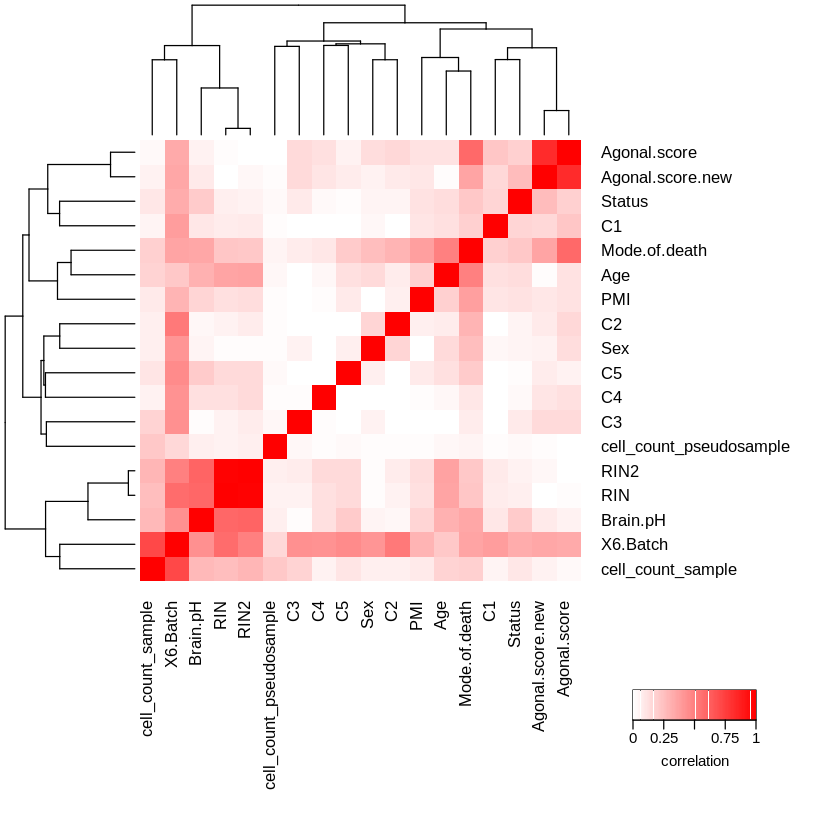

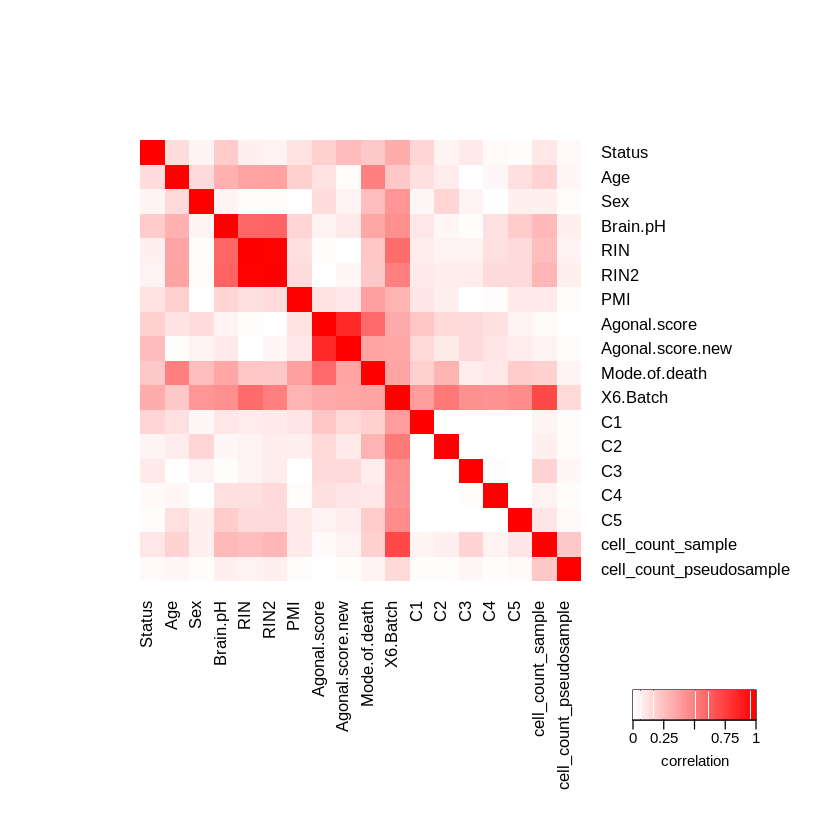

In [24]:
# analyze correlation of covariates
# canonical correlation analysis CCA
form <- as.formula("~ Status +
  Age +
  Sex +
  Brain.pH + RIN + RIN2 +
  PMI + Agonal.score + Agonal.score.new + Mode.of.death +
  X6.Batch +
  C1+C2+C3+C4+C5+
  cell_count_sample +
  cell_count_pseudosample")
  
  # Calculate the correlation coefficients
  C <- canCorPairs(form, metadata)
  # Plot the results using Canonical correlation
  # sorted
  plotCorrMatrix(C)
  # unsorted
  plotCorrMatrix(C, sort = FALSE)

In [25]:
# save counts and metadata object as rds
saveRDS(metadata, paste0(tabledir, "/metadata.rds"))
saveRDS(counts, paste0(tabledir, "/counts.rds"))